# Imports

In [88]:
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import utils
from prophet import Prophet

In [89]:
X, y = utils.get_train_data()

In [90]:
len(y), X.shape

(496827, (496827, 10))

In [91]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = X["date"] <= cutoff_date
    X_train, X_test = X.loc[mask], X.loc[~mask]
    y_train, y_test = y[mask], y[~mask]

    return X_train, y_train, X_test, y_test

In [92]:
X_train, y_train, X_test, y_test = train_test_split_temporal(
    X, y, delta_threshold="30 days"
)

# PROPHET

In [93]:
# creating a df for prophet
df_train = X_train.reset_index().copy()

df_train["y"] = pd.Series(y_train)

df_train = df_train[["date", "latitude", "longitude", "y"]]
df_train.rename(columns={"date": "ds"}, inplace=True)

In [94]:
df_train.head()

,ds,latitude,longitude,y
0,2020-09-01 01:00:00,48.840801,2.333233,1.609438
1,2020-09-01 01:00:00,48.840801,2.333233,1.386294
2,2020-09-01 01:00:00,48.853720,2.357020,0.000000
3,2020-09-01 01:00:00,48.853720,2.357020,0.693147
4,2020-09-01 01:00:00,48.885290,2.326660,2.079442


In [95]:
model = Prophet()

In [96]:
model.add_regressor("latitude")
model.add_regressor("longitude")

model.fit(df_train)

14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:08 - cmdstanpy - INFO - Chain [1] done processing


In [97]:
# creating a df for prophet
df_test = X_test.reset_index().copy()

df_test["y"] = pd.Series(y_test)

df_test = df_test[["date", "latitude", "longitude", "y"]]
df_test.rename(columns={"date": "ds"}, inplace=True)

In [98]:
future = model.make_future_dataframe(periods=30)  # Adjust 'periods' as needed

# Add future values for your regressors
future["latitude"] = df_test["latitude"]  # Replace with your future data
future["longitude"] = df_test["longitude"]

In [99]:
forecast = model.predict(future)

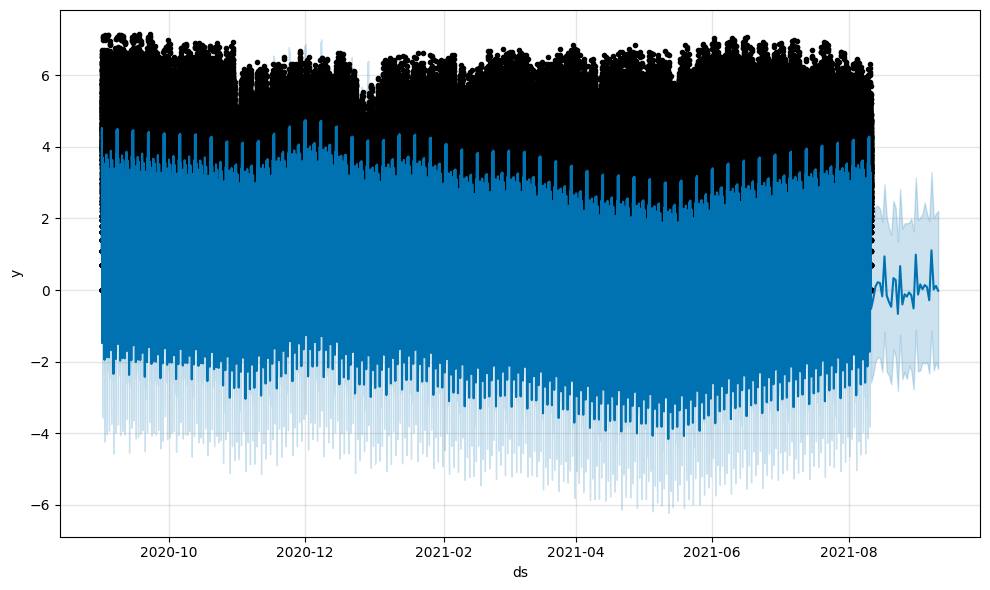

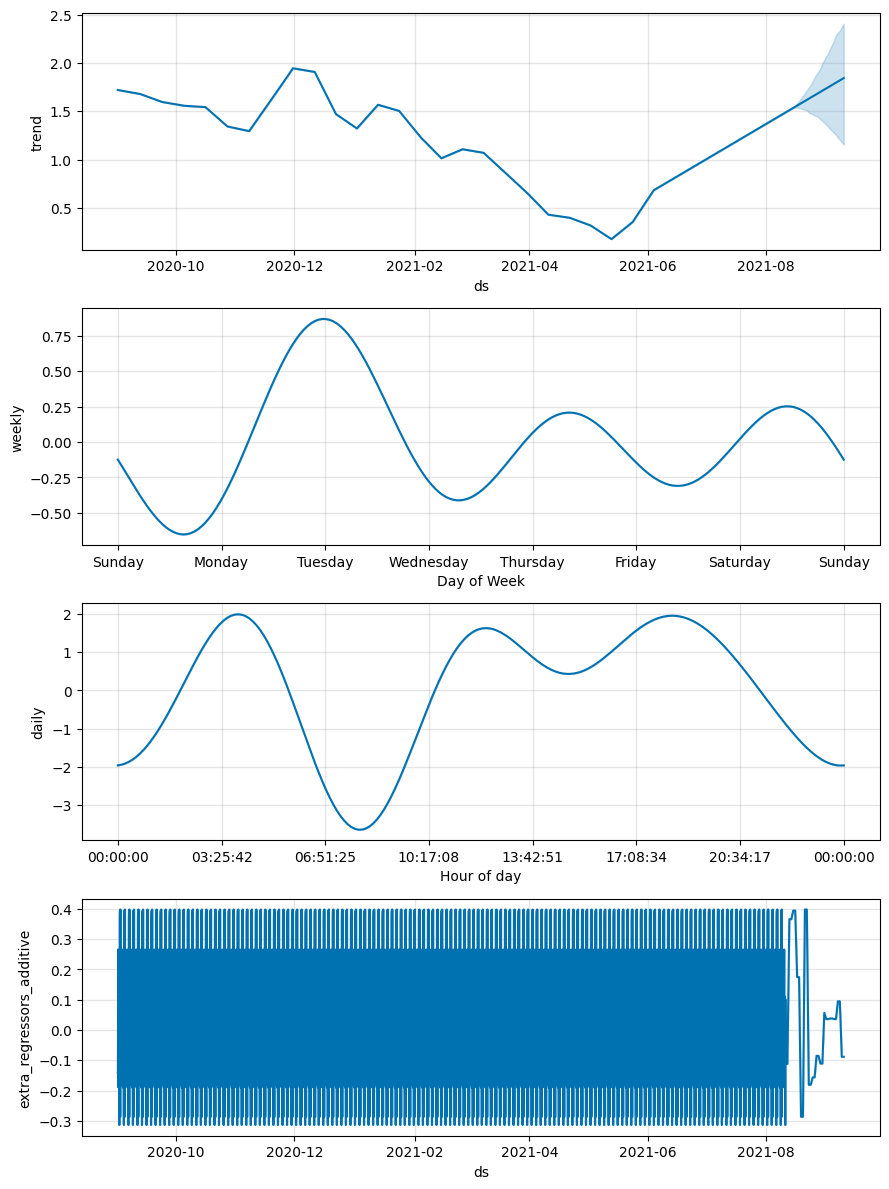

In [100]:
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)